# 

# 
Developed as part of European Union Horizon 2020 programme funded SCALE-UP project (grant agreement no. 955332).

## Import libraries, functions and constants

In [10]:
import pandas as pd
from xgboost import XGBRegressor
from utils import (
    compare_test_with_predicition,
    fit_model,
    get_filtered_merged_data,
    get_pipeline,
    predict,
    draw_results,
    print_results,
    BASE,
    MINUS_10,
    MINUS_20,
    ZERO,
    PLUS_10,
    PLUS_20,
    DRY_WEATHER,
    SEASONABILITY_COLUMNS,
    RAIN,
    RAIN_BOOL,
    TEMPERATURE,
    YEAR,
    RAIN_VALUE,
)

## Load and prepare data

In [11]:
df_base, df_rain_train, df_rain_bool_train, df_temperature_train = get_filtered_merged_data("../data/parkings_small.csv")

Found 718955 parkings in zone


## Create pipelines and train models

mean squared error for model base: 4699.39306640625
mean squared error for model rain: 4684.4501953125
mean squared error for model rain boolean: 4694.55615234375
mean squared error for model temperature: 4130.99755859375


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'month',
                                                   'dayofweek']),
                                                 ('Standard', StandardScaler(),
                                                  ['temperature', 'year'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsa...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=22, ...))])

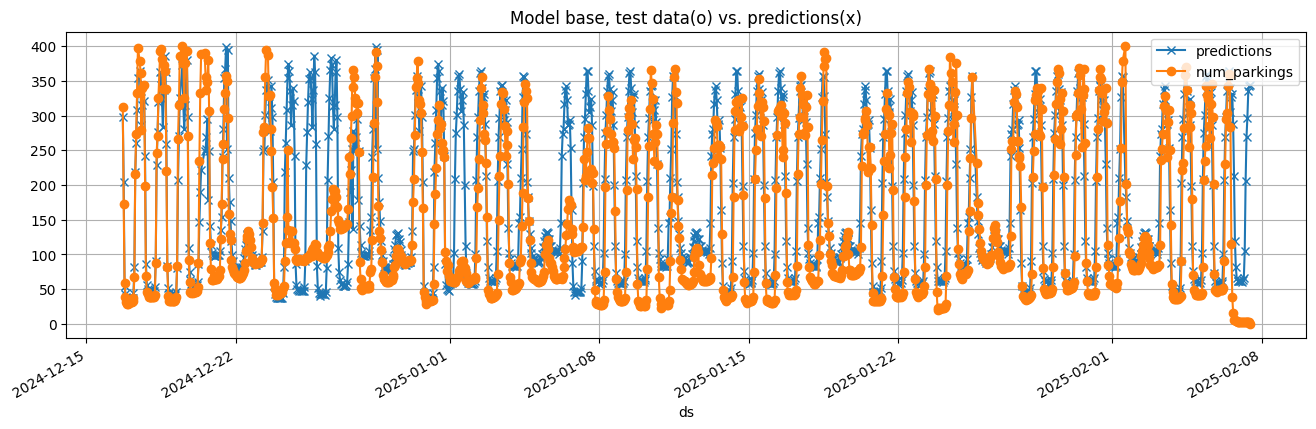

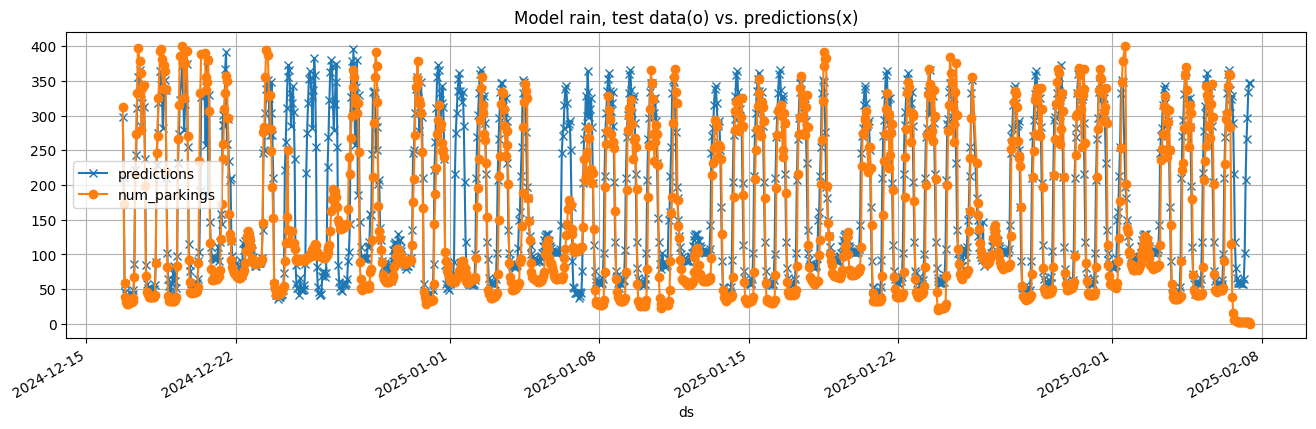

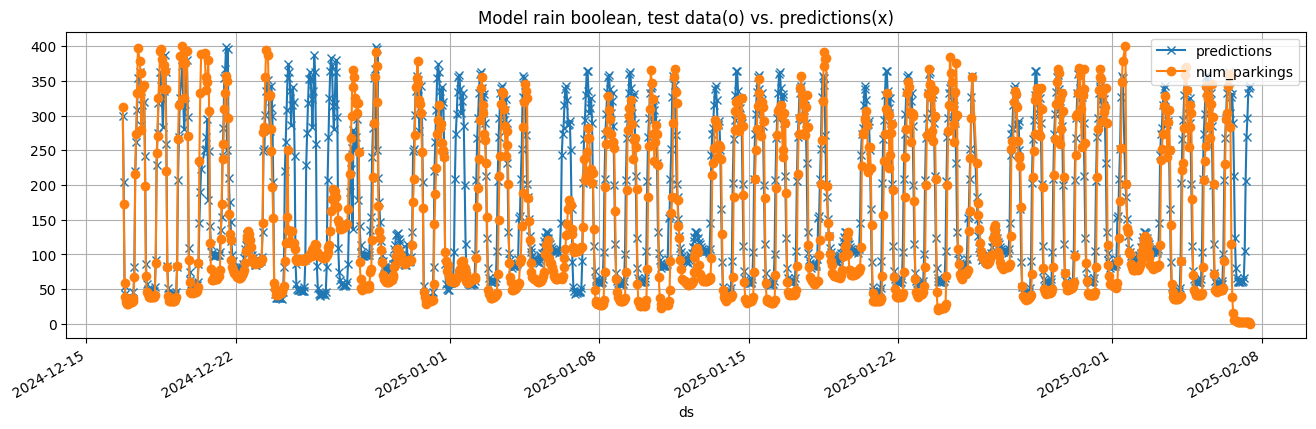

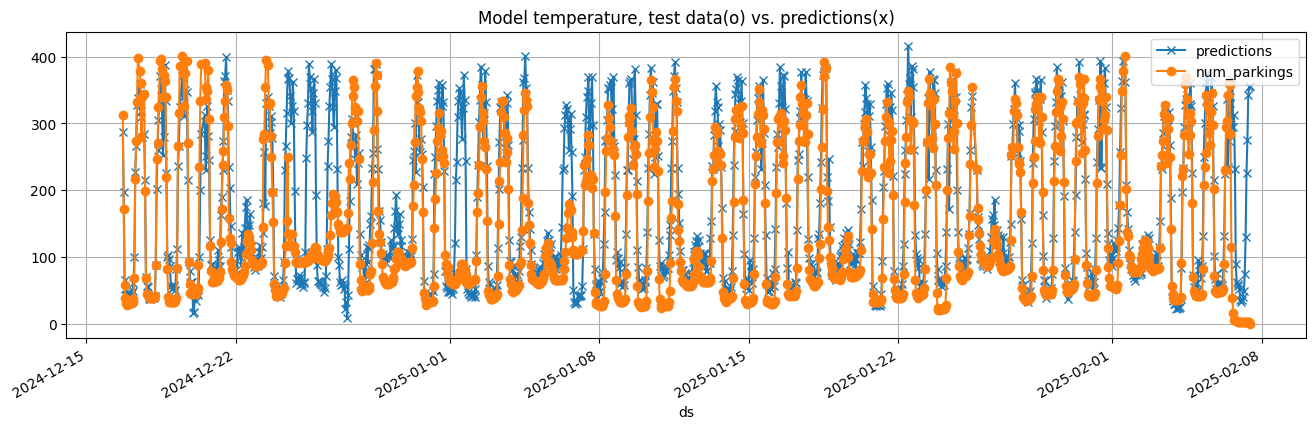

In [12]:
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.1, max_depth=None, random_state=42)
pipeline = get_pipeline(xgb_model, standard_columns=[YEAR])
X_test, y_test = fit_model(pipeline, df_base, SEASONABILITY_COLUMNS)
compare_test_with_predicition(pipeline, X_test, y_test, model_name=BASE)

xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.1, max_depth=None, random_state=32)
pipeline_rain = get_pipeline(xgb_model, standard_columns=[YEAR, RAIN])
X_test, y_test = fit_model(pipeline_rain, df_rain_train, SEASONABILITY_COLUMNS+[RAIN])
compare_test_with_predicition(pipeline_rain, X_test, y_test, model_name=RAIN)

xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.1, max_depth=None, random_state=32)
pipeline_rain_bool = get_pipeline(xgb_model, standard_columns=[YEAR, RAIN])
X_test, y_test = fit_model(pipeline_rain_bool, df_rain_bool_train, SEASONABILITY_COLUMNS+[RAIN])
compare_test_with_predicition(pipeline_rain_bool, X_test, y_test, model_name=RAIN_BOOL)

xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.1, max_depth=None, random_state=22)
pipeline_temperature = get_pipeline(xgb_model, standard_columns=[TEMPERATURE, YEAR])
X_test, y_test = fit_model(pipeline_temperature, df_temperature_train, SEASONABILITY_COLUMNS+[TEMPERATURE])
compare_test_with_predicition(pipeline_temperature, X_test, y_test, model_name=TEMPERATURE)

## Make predictions

In [13]:
results = {}
date_range = pd.date_range(start="2025-02-07 11:00:00", end="2025-03-09 11:00:00", freq="h")
results[BASE] = predict(pipeline, date_range)
results[RAIN] = predict(pipeline_rain, date_range, rain=RAIN_VALUE)
results[RAIN_BOOL] = predict(pipeline_rain_bool, date_range, rain=True)
results[DRY_WEATHER] = predict(pipeline_rain, date_range, rain=False)
results[MINUS_20] = predict(pipeline_temperature, date_range, temperature=-20)
results[MINUS_10] = predict(pipeline_temperature, date_range, temperature=-10)
results[ZERO] = predict(pipeline_temperature, date_range, temperature=0)
results[PLUS_10] = predict(pipeline_temperature, date_range, temperature=10)
results[PLUS_20] = predict(pipeline_temperature, date_range, temperature=20)
print_results(date_range, results)

Forecast period: 2025-02-07 11:00:00 - 2025-03-09 11:00:00
Base forecast for parkings: 123384.
Forecast for parkings in rain: 124822.  Diff to base 1438 (1.17%)
Forecast for parkings in rain boolean: 124083.  Diff to base 699 (0.57%)
Forecast for parkings in dry weather: 123355.  Diff to base -29 (-0.02%)
Forecast for parkings in -20 degrees temperature: 118166.  Diff to base -5218 (-4.23%)
Forecast for parkings in -10 degrees temperature: 118166.  Diff to base -5218 (-4.23%)
Forecast for parkings in 0 degrees temperature: 114495.  Diff to base -8889 (-7.2%)
Forecast for parkings in 10 degrees temperature: 124685.  Diff to base 1301 (1.05%)
Forecast for parkings in 20 degrees temperature: 128635.  Diff to base 5251 (4.26%)


### Model Comparison
Mean squared error (model accuracy):
* Model base: 4699
* Model rain: 4684
* Model rain boolean: 4694
* Model temperature: 4130 

The performance metrics are worse than with MLPRegression but better than with LinearRegression.

### Weather Impact Analysis 
Weather impace was measured by forecasting 30 days in future with given static weather values.  Forecast total cars is a sum of all hourly cars in the 30 day period. 
| Condition                       | Forecast | Diff to Base | % Diff  |
|----------------------------------|----------|--------------|---------|
| Base forecast                    | 123,384  | -            | -       |
| Rain                             | 124,822  | 1,438        | 1.17%   |
| Rain (Boolean)                   | 124,083  | 699          | 0.57%   |
| Dry Weather                      | 123,355  | -29          | -0.02%  |
| -20°C Temperature                | 118,166  | -5,218       | -4.23%  |
| -10°C Temperature                | 118,166  | -5,218       | -4.23%  |
| 0°C Temperature                  | 114,495  | -8,889       | -7.2%   |
| 10°C Temperature                 | 124,685  | 1,301        | 1.05%   |
| 20°C Temperature                 | 128,635  | 5,251        | 4.26%   |

### Key Insights
1. **Rain:** 
   - The forecast for parkings in rain is 124,822, showing a slight increase of 1,438 (1.17%) compared to the base forecast.
   - **Rain (Boolean):** A similar increase of 699 (0.57%) is observed when considering rain in Boolean terms, with a forecast of 124,083 parkings.
    - **Dry Weather:** In dry weather conditions, the forecast is almost identical to the base, with a minor decrease of 29 parkings (-0.02%).
2. **Cold Temperatures:**
   - At **-20°C** and **-10°C**, the forecast decreases significantly by 5,218 parkings (-4.23%) in each case.
   - At **0°C**, the forecast is even lower, showing a reduction of 8,889 parkings (-7.2%).
3. **Warmer Temperatures:**
   - At **10°C**, the forecast increases by 1,301 parkings (1.05%).
   - At **20°C**, the forecast sees the highest increase, with an additional 5,251 parkings (4.26%).

## Draw predictions

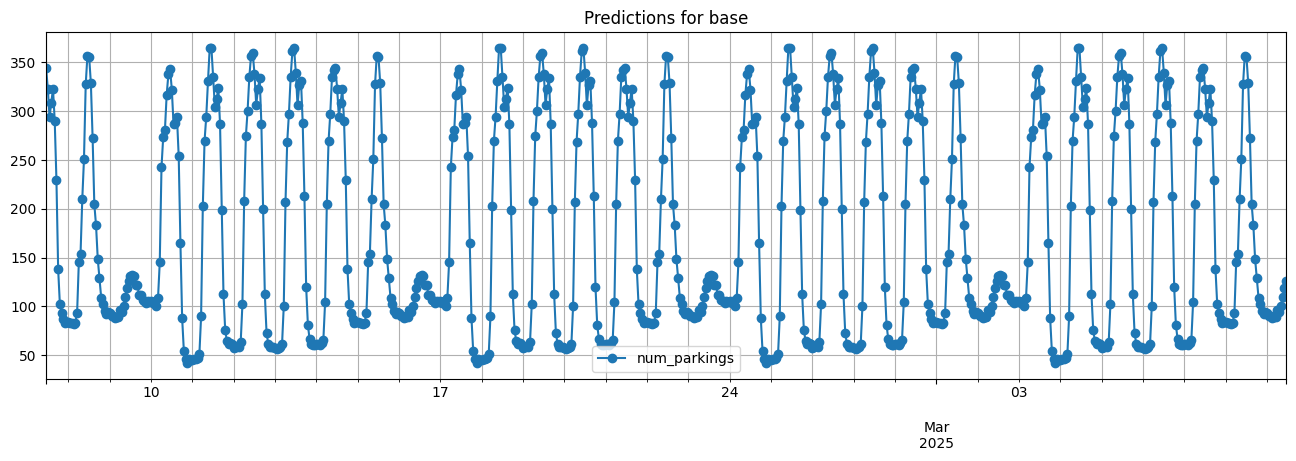

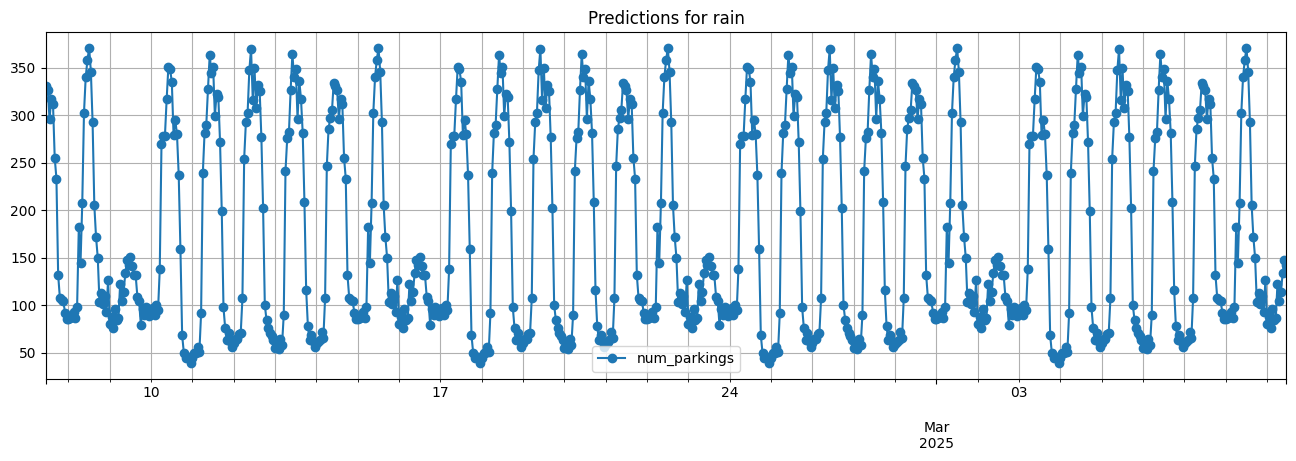

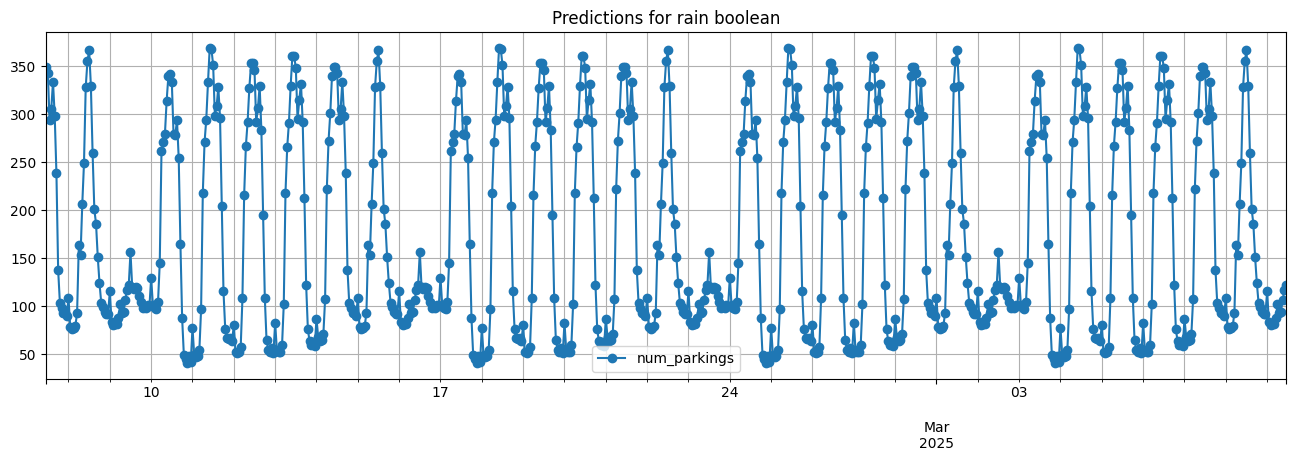

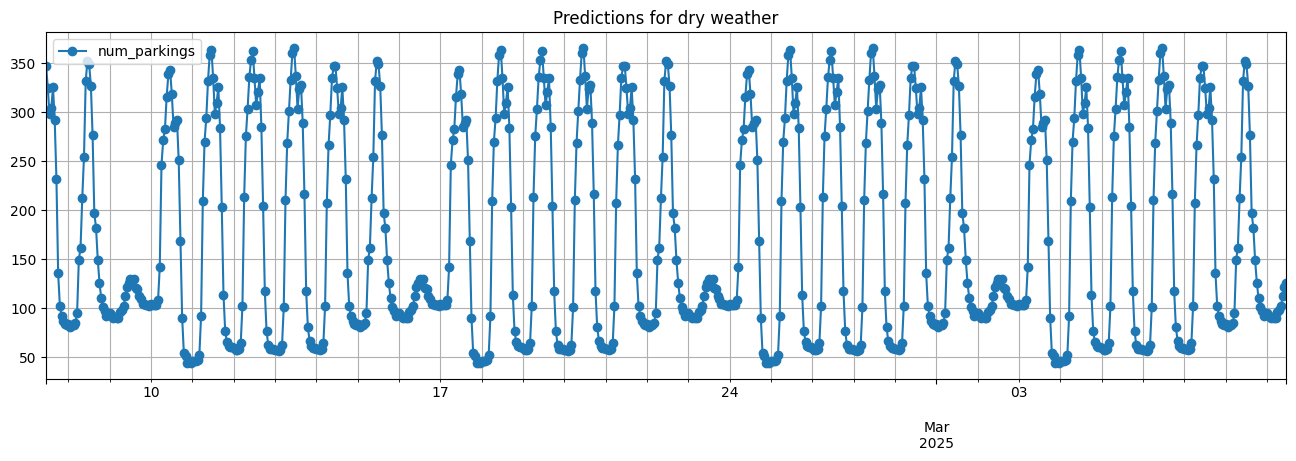

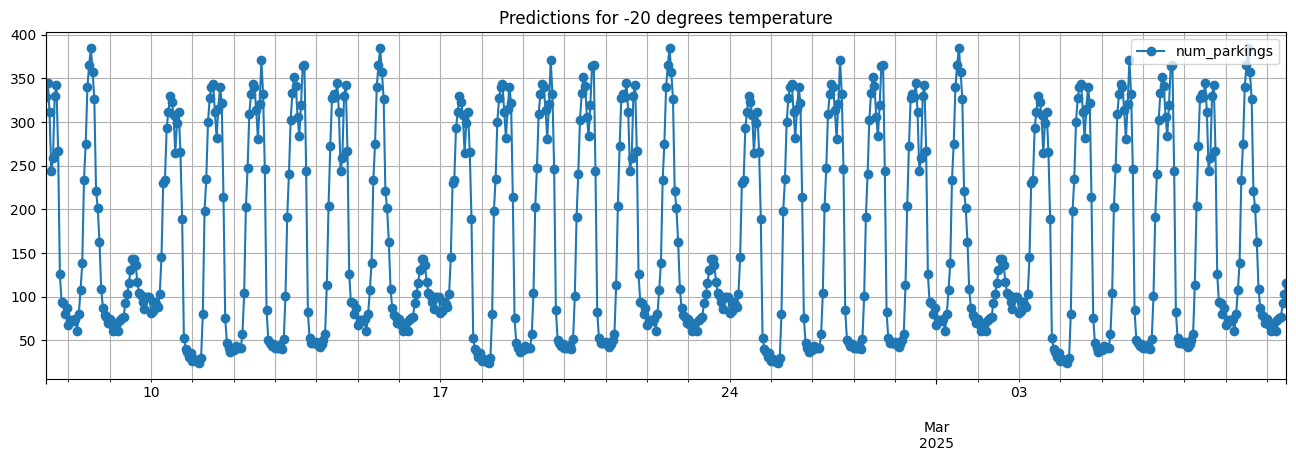

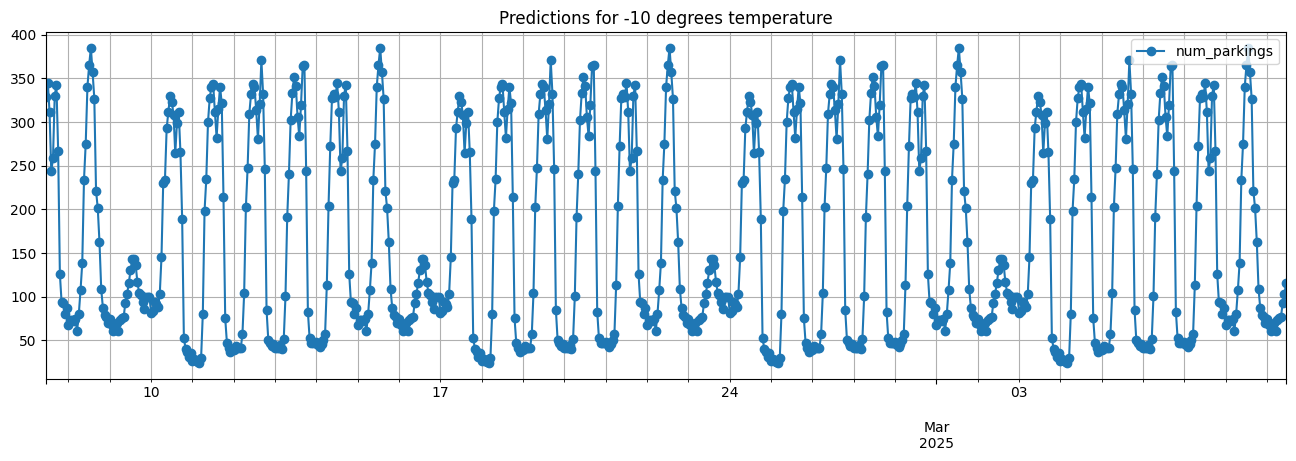

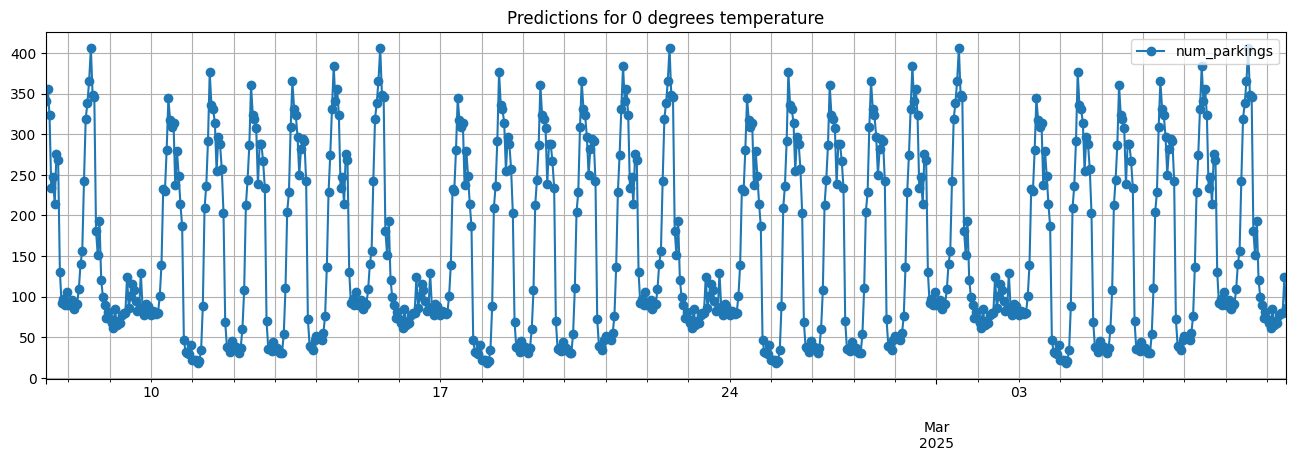

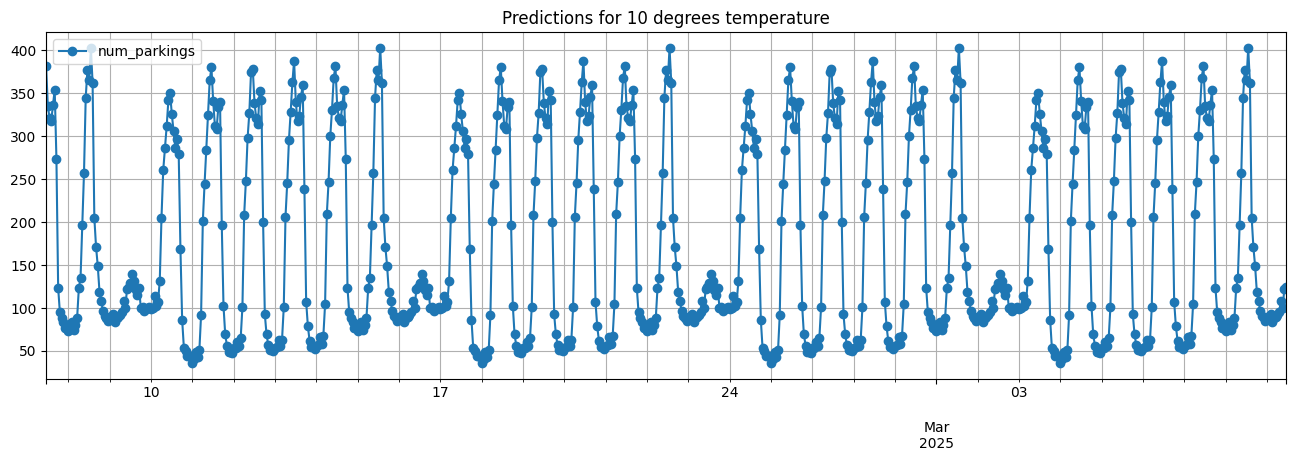

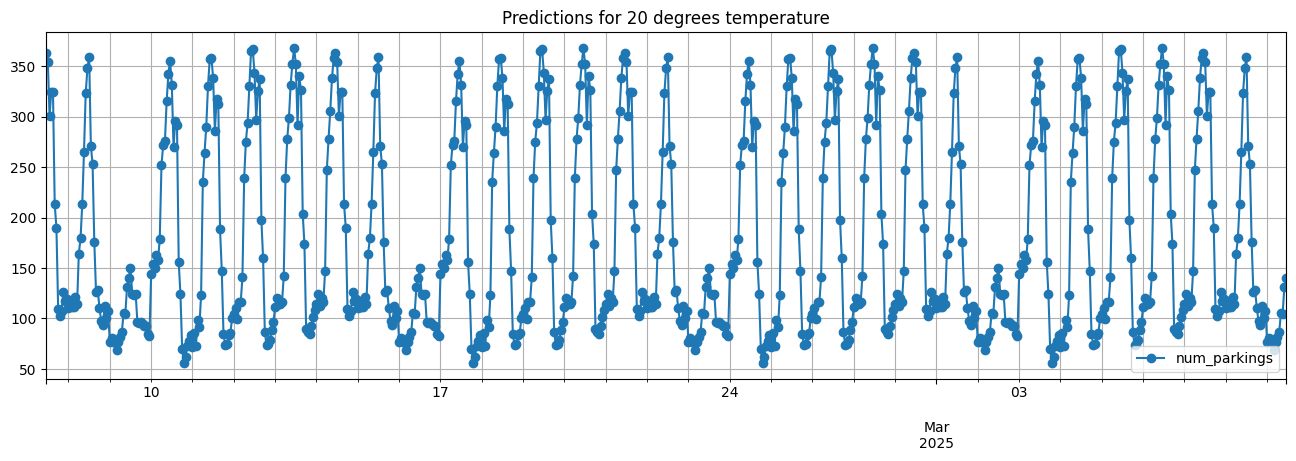

In [14]:
draw_results(results)